In [11]:
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en
from data_handling.basic_plot import decim, plot_raster, make_psth, col_binned
from data_handling import data_load as dl
from data_handling.data_load import get_warping_parameters
from analysis import stimulus as st
from analysis import response_functions as rf


#load all the records, to not load all the records for every stimulus
fn = en.file_names(root = experiment_folder)
cells_path = os.path.join(fn.fold_exp_data, 'data_play')
uf = dl.list_cells(cells_path)
all_cells = [f for f in uf if f.find('ZKawakeM72_029')>-1]
all_cells = uf
#print all_cells
all_records = dl.load_cells(cells_path, all_cells)

#all_records = dl.load_cells(cells_path)

## create a stimulus and initialize it (load its responses)
high_2hydroxy = st.Odor(['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051)
st_1 = st.Stimulus(high_2hydroxy, records = all_records, tags = {'light':1} )

#get the first response and plot it
warp = True
#st_1.responses['ZKawakeM72_013_e_010'].get_response_onset(warped=warp)
#rp = st_1.responses['ZKawakeM72_013_e_010'].plot(warped=warp)

#make all the odor stimuli
tags = {'light':1}
# {odor_name: [stim_aliases], conc, records, tags, extra_plot_pars}

all_odors_list = {'2-hydroxy_high': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051, 
                  all_records, tags, {'color': '#9F000F', 'alpha': 1.}],
                  
                  '2-hydroxy_med': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 2.97e-4,
                                    all_records, tags, {'color': '#F62217', 'alpha': .5}],
                  
                  '2-hydroxy_low': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 1.8e-5,
                                    all_records, tags, {'color': '#E77471', 'alpha': .25}],
                  
                  'ethyl_tiglate': [['ethyl_tiglate','ethyltiglate'], 1.3e-4,
                                    all_records, tags, {'color': '#41a317', 'alpha': 1.}],
                  
                  'acetophenone': [['acetophenone','acetoph'], 7.9e-4, 
                                   all_records, tags, {'color': '#43c6db', 'alpha': 1.}],
                  
                  '4-methyl': [['4-methylacetophenone','4methyl'], 1.8e-3,
                               all_records, tags, {'color': '#FF00FF', 'alpha': 1.}],
                  
                  'benzaldehyde': [['benzaldehyde', 'benz'], 1.9e-4,
                                   all_records, tags, {'color': '#F88017', 'alpha': 1.}],
                  
                  '2-4-dimethyl': [['2-4-dimethylacetophenone', '24-dimethylacetophenone'], 5.8e-3, 
                                   all_records, tags, {'color': '#FFD801', 'alpha': 1.}],
                  
                  'menthone_high': [['menthone', 'mentone'], 1.6e-2,
                                    all_records,tags, {'color': '#000080', 'alpha': 1.}],
                  
                  'menthone_med': [['menthone', 'mentone'], 1.6e-3,
                                   all_records, tags, {'color': '#1569c7', 'alpha': 0.5}],
                  
                  'menthone_low': [['menthone', 'mentone'], 7e-5,
                                   all_records, tags, {'color': '#188AC7', 'alpha': .25}]
                 }
all_odors = {}
for key, sd in all_odors_list.iteritems():
    all_odors.update({key: st.Stimulus(st.Odor(sd[0], sd[1]), records=sd[2], tags=sd[3], extra_plot_pars=sd[4])})

print all_odors.keys()
#[r.plot(warped=True) for r in list(st_1.responses.values())]

Computer: server
/experiment/export_data/data_play/KPawakeM72_014_001_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_004_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_006_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_007_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_012_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_017_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_001_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_005_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_006_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_007_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_008_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_009_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_010_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_011_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_012_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_016_

In [52]:
import multiprocessing

def worker(procnum, stim_list):
    #print str(procnum)
    warp = False
    bin_size = 15
    p=0.05
    if type(stim_list) is not list:
        stim_list = [stim_list]
    for stim in stim_list:
        for r_name, r in list(stim.responses.iteritems()):
            try:
                r.get_response_onset(warped=warp, bin_size=bin_size, p_ks=p)
                r.get_spike_count()
                #r.plot(warped=warp)
            except:
                print 'fail in ' + r_name

In [51]:
#get all the population rec
all_odors_population = {}
for key, sd in all_odors_list.iteritems():
    all_odors_population.update({key: st.Stimulus(st.Odor(sd[0], sd[1]), records=sd[2], tags = {'light':0}, extra_plot_pars=sd[4])})

In [53]:
procs = 8
jobs =[]
n_stim = len(all_odors)
stim_per_proc = int(math.ceil(n_stim/procs))

for i in range(0, procs):
    keys = all_odors_population.keys()[i*stim_per_proc: (i+1)*stim_per_proc]
    stim = [all_odors_population[key] for key in keys]
   
    if not stim == []:
        print keys
        print i
        process = multiprocessing.Process(target=worker(i, stim))
        jobs.append(process)

[j.start() for j in jobs]
[j.join() for j in jobs]

['ethyl_tiglate', '4-methyl']
0
fail in KPawakeM72_014_b_017
fail in ZKawakeM72_011_c_012
['menthone_med', 'menthone_high']
1
fail in ZKawakeM72_028_b_012
['acetophenone', '2-4-dimethyl']
2
fail in KPawakeM72_014_b_017
fail in ZKawakeM72_011_c_012
['menthone_low', '2-hydroxy_med']
3
fail in KPawakeM72_024_c_003
['2-hydroxy_high', '2-hydroxy_low']
4
fail in ZKawakeM72_029_d_011
fail in ZKawakeM72_029_d_010
fail in ZKawakeM72_029_d_012
fail in ZKawakeM72_011_c_012
['benzaldehyde']
5


[None, None, None, None, None, None]

In [58]:
#plot all the responses to all the stimuli
response_row = np.zeros(1, dtype=[('stim', '|S32'), ('resp', '|S32'), ('latency', 'f4'), ('onset_lvl','f4'), 
                                  ('spikes_inh', 'f4'), ('spikes_exh', 'f4'), ('spikes', 'f4'), ('ratio','f4')]) 
non_litrals = np.zeros_like(response_row)
#print litrals
warp = False
bin_size = 15
p=0.05
for st_name, stim in all_odors_population.iteritems():
    #print st_name
    #print stim.responses.keys()
    for r_name, r in list(stim.responses.iteritems()):
        this_resp = np.zeros_like(response_row)
        this_resp['stim'] = st_name
        this_resp['resp'] = r_name
        if r.response_onset is None:
            continue
        this_resp['latency'] = r.response_onset['onset']
        this_resp['onset_lvl'] = r.response_onset['response'] - r.response_onset['baseline']
        this_resp['spikes_inh'] = r.spikes['inh']
        this_resp['spikes_exh'] = r.spikes['exh']
        this_resp['spikes'] = this_resp['spikes_inh'] + this_resp['spikes_exh']
        this_resp['ratio'] = this_resp['spikes_inh']/this_resp['spikes_exh']
        non_litrals = np.append(non_litrals, this_resp)
        #r.plot(warped=warp)

In [4]:
#get a list of cells, a list of stimuli and compute them all in parallel
#load all the records, to not load all the records for every stimulus
fn = en.file_names(root = experiment_folder)
cells_path = os.path.join(fn.fold_exp_data, 'data_play')
uf = dl.list_cells(cells_path)
all_cells = [f for f in uf if f.find('KPawakeM72_019')>-1]
print all_cells
all_records = dl.load_cells(cells_path, all_cells)
#all_records = dl.load_cells(cells_path)

#get the first response and plot it
warp = True
#st_1.responses['ZKawakeM72_013_e_010'].get_response_onset(warped=warp)
#rp = st_1.responses['ZKawakeM72_013_e_010'].plot(warped=warp)

#make all the odor stimuli
tags = {'light':1}

odor_dicts_list = []
recs_list = []
path_list = []

for key, sd in all_odors_list.iteritems():
    one_odor = {key: st.Stimulus(st.Odor(sd[0], sd[1]), records=sd[2], tags=sd[3], extra_plot_pars=sd[4])}
    odor_dicts_list.append(one_odor)
    recs_list.append(sd[2])
    path_list.append(cells_path)



['KPawakeM72_019_002', 'KPawakeM72_019_003', 'KPawakeM72_019_004', 'KPawakeM72_019_005', 'KPawakeM72_019_006', 'KPawakeM72_019_007', 'KPawakeM72_019_010', 'KPawakeM72_019_011', 'KPawakeM72_019_013', 'KPawakeM72_019_014', 'KPawakeM72_019_015', 'KPawakeM72_019_018', 'KPawakeM72_019_020', 'KPawakeM72_019_021']
/experiment/export_data/data_play/KPawakeM72_019_002_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_003_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_004_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_005_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_006_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_007_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_010_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_011_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_013_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_014_cell.mat
/experiment/export_data/data_play/KPawakeM72_019_015_cell.mat
/experime

['ethyl_tiglate', '4-methyl']
0
fail in KPawakeM72_014_b_012
['menthone_med', 'menthone_high']
1
fail in ZKawakeM72_020_g_001
['acetophenone', '2-4-dimethyl']
2
fail in KPawakeM72_016_a_018
fail in KPawakeM72_014_b_012
fail in ZKawakeM72_006_a_001
['menthone_low', '2-hydroxy_med']
3
fail in KPawakeM72_024_c_002
['2-hydroxy_high', '2-hydroxy_low']

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)



4
['benzaldehyde']
5


[None, None, None, None, None, None]

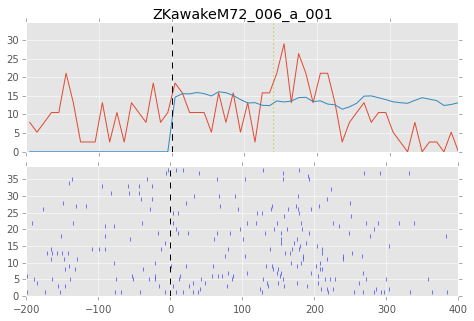

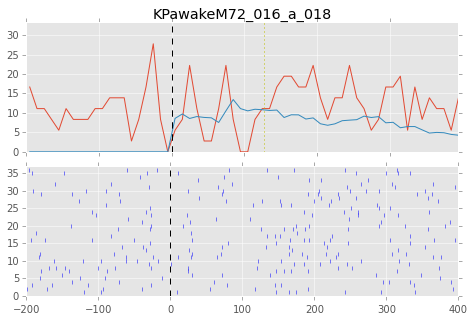

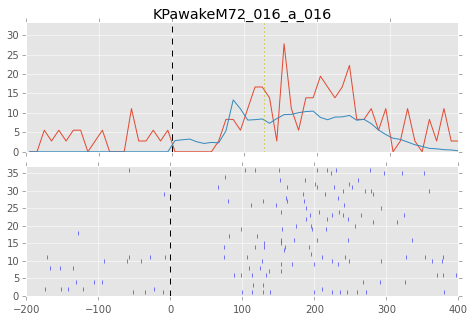

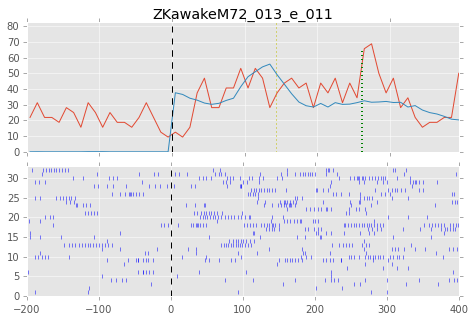

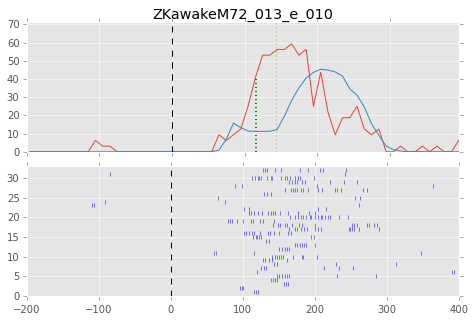

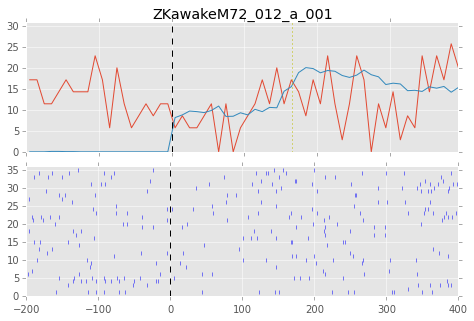

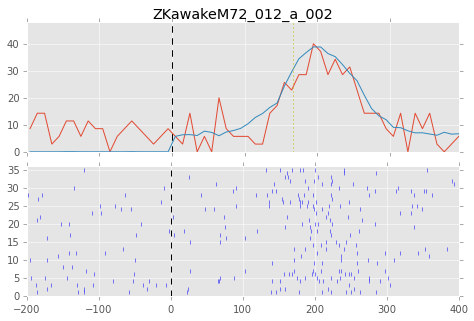

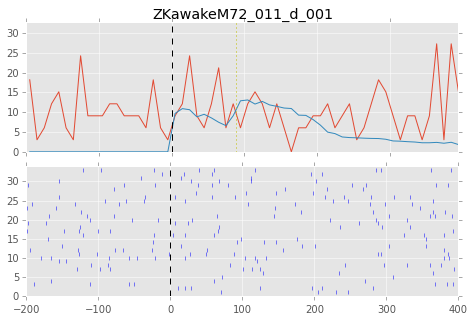

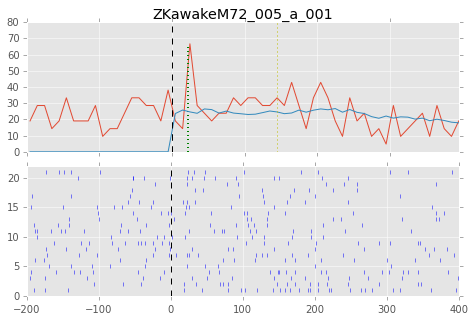

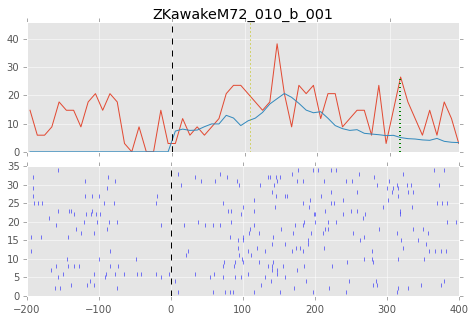

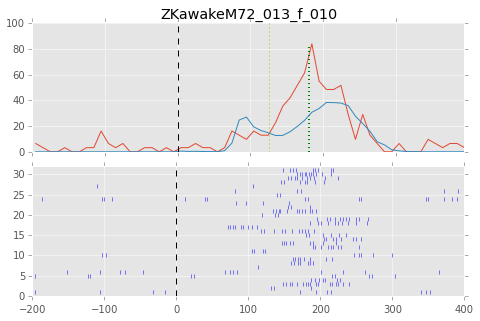

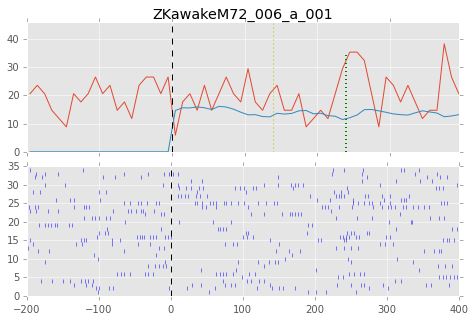

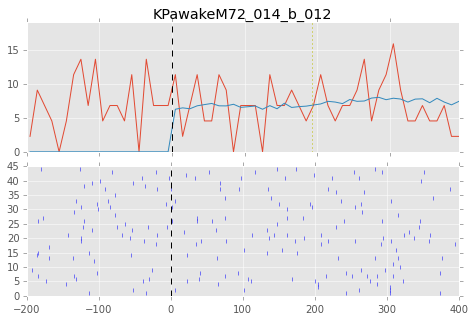

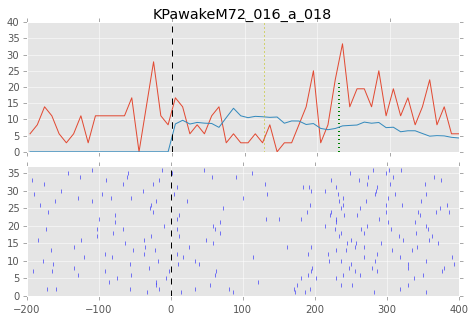

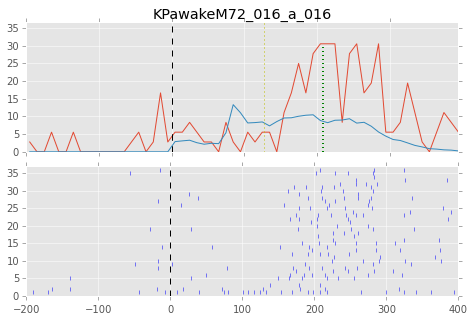

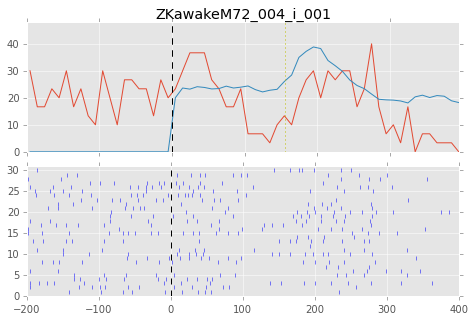

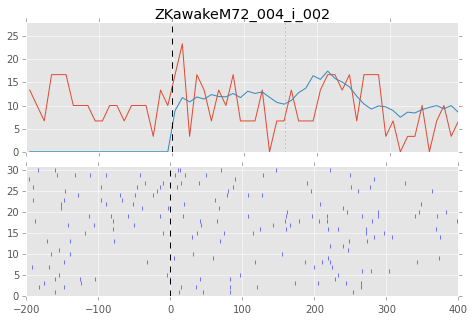

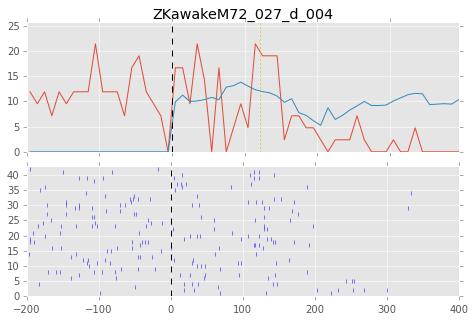

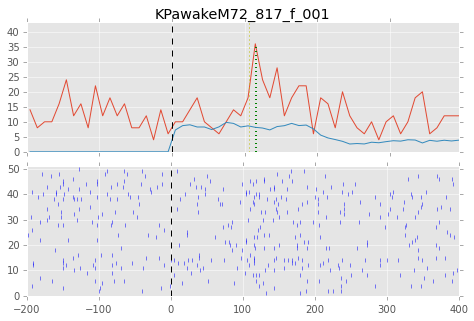

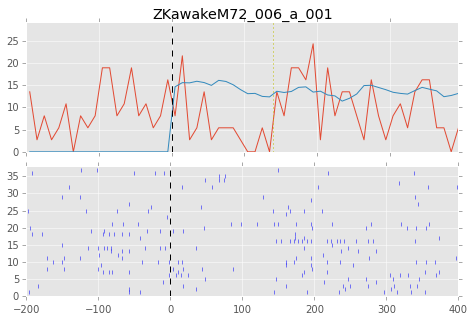

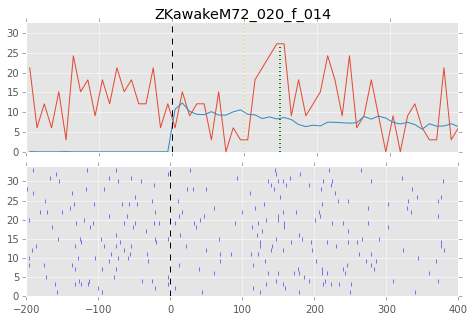

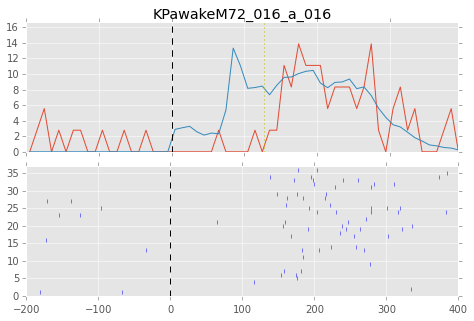

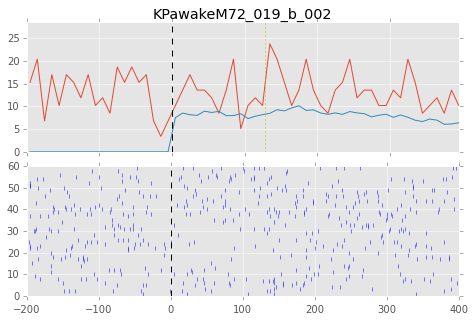

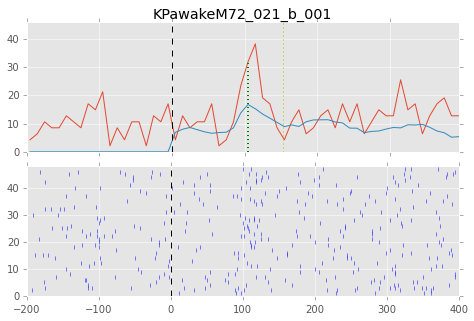

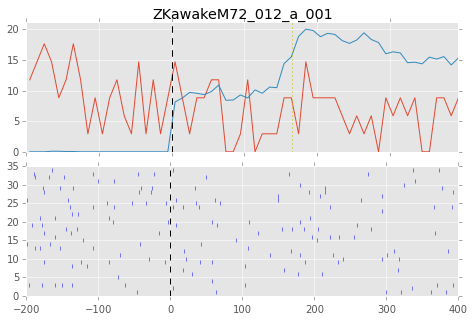

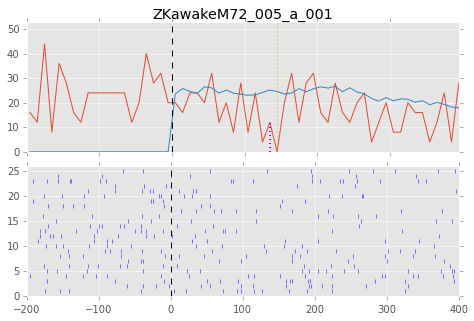

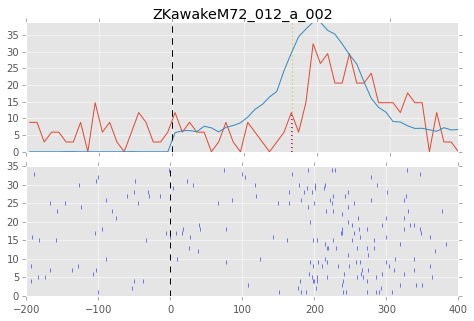

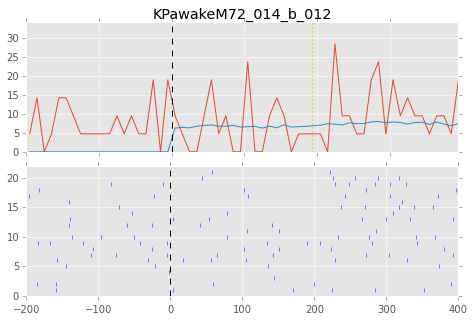

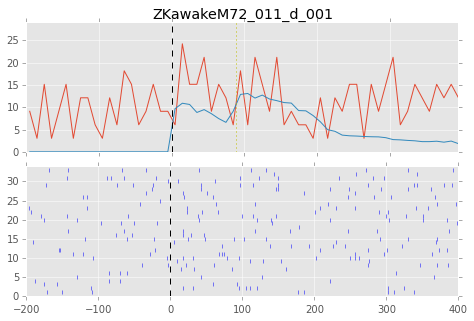

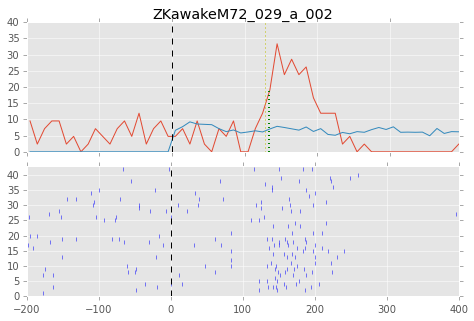

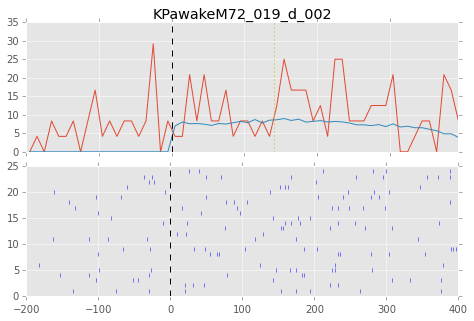

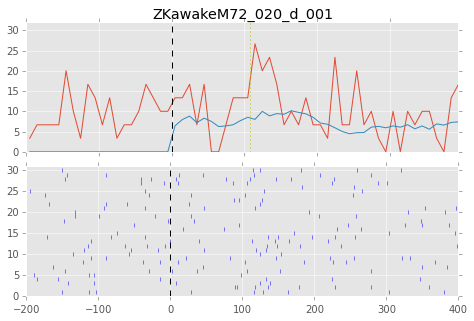

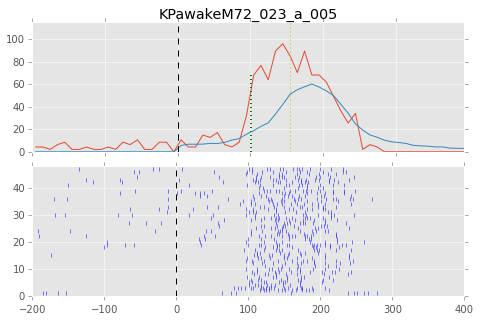

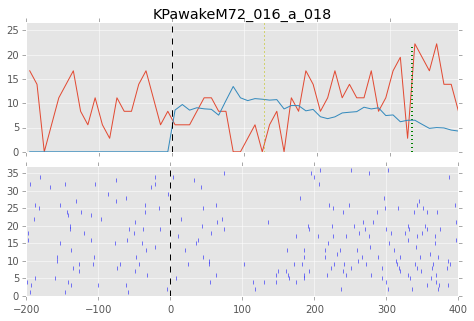

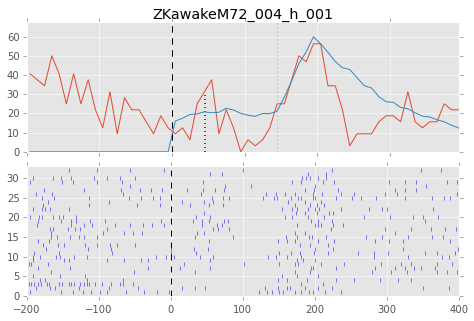

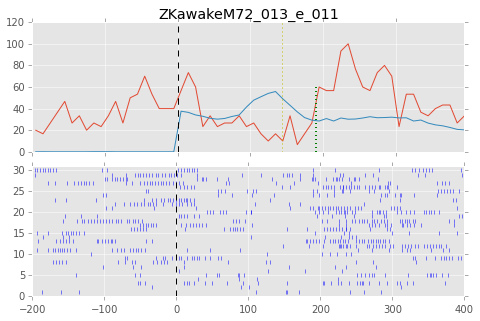

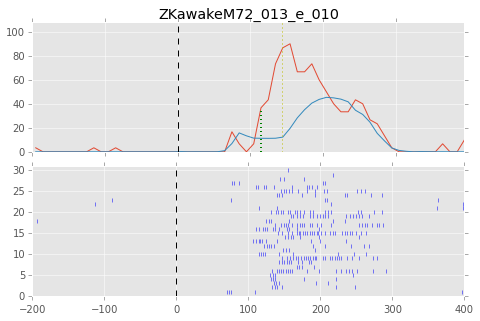

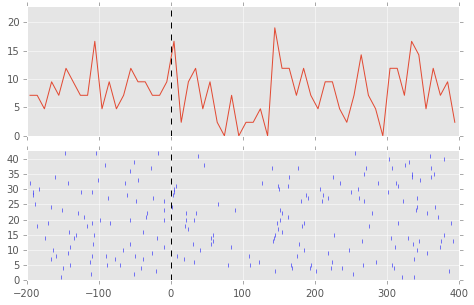

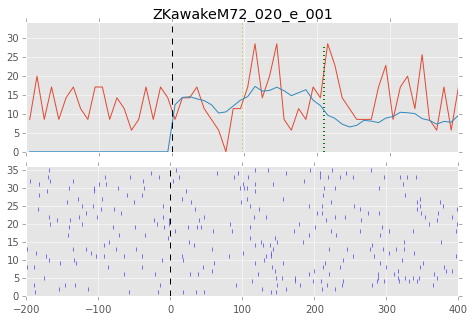

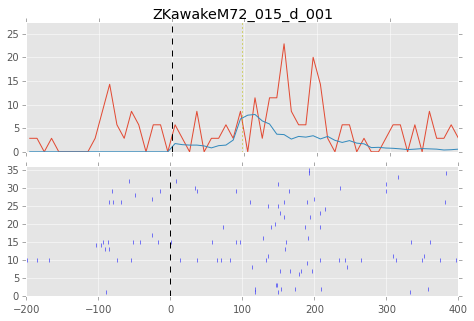

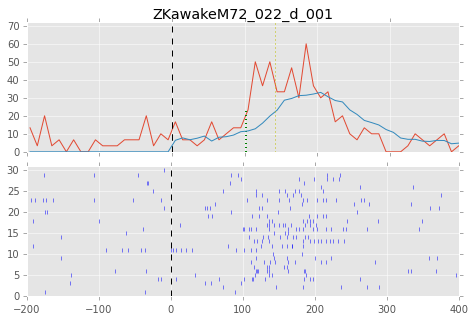

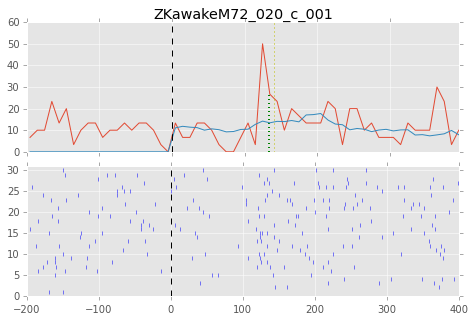

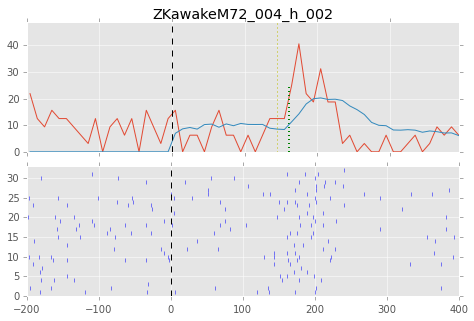

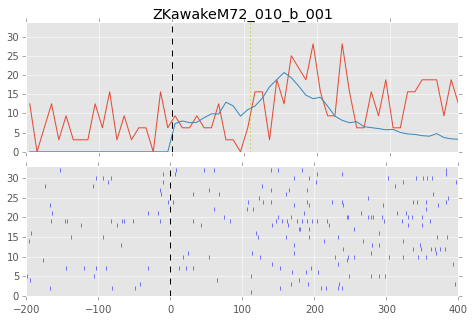

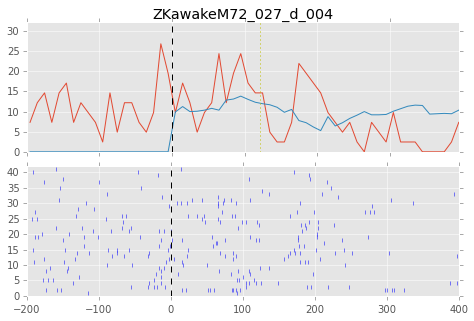

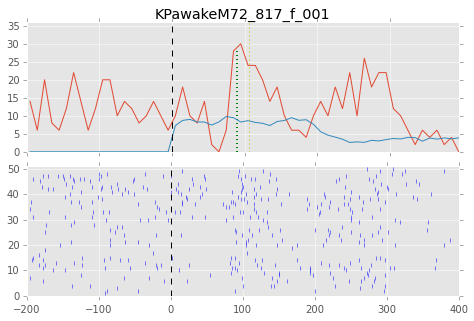

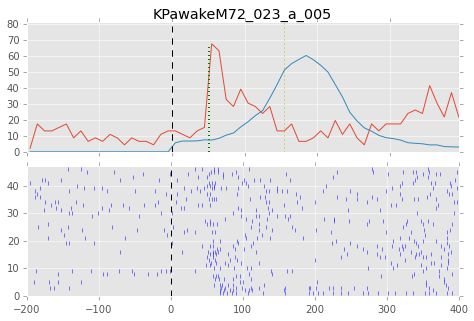

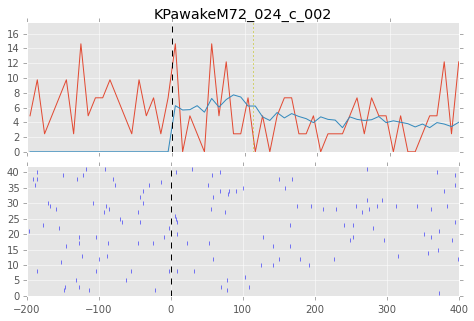

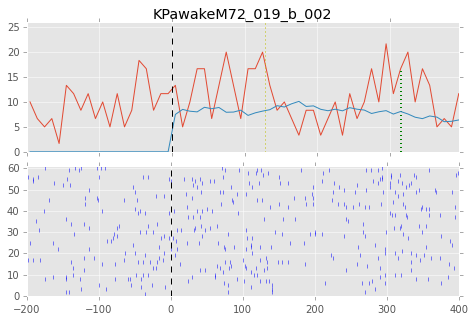

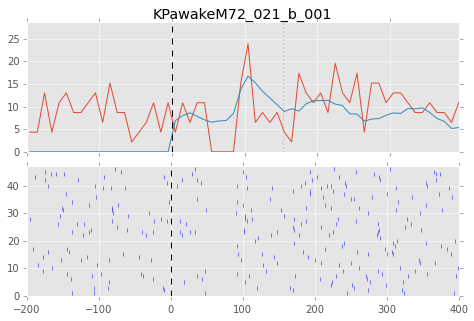

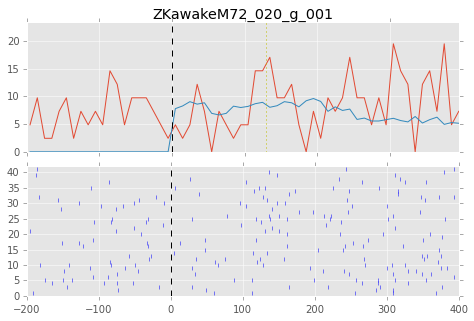

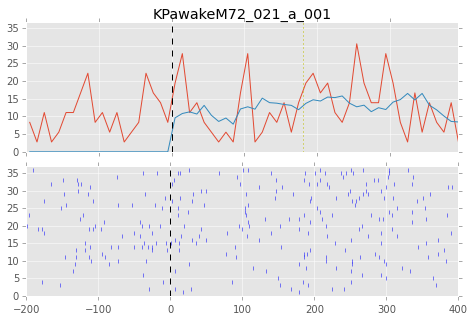

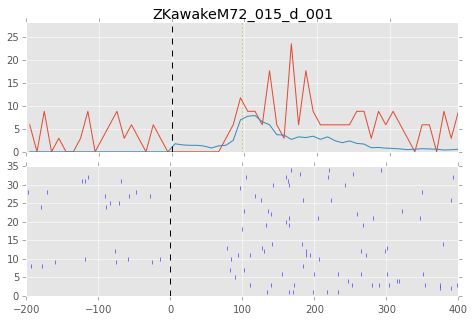

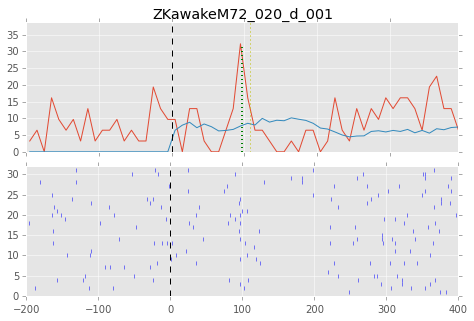

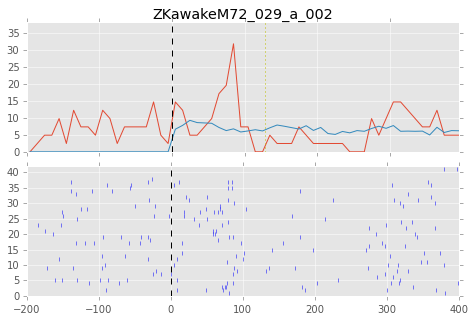

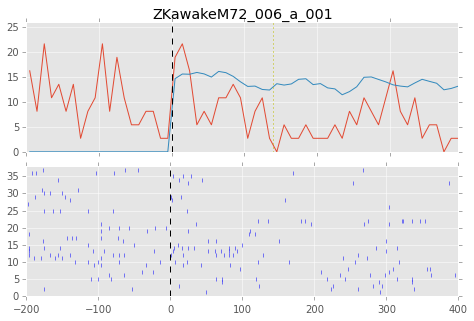

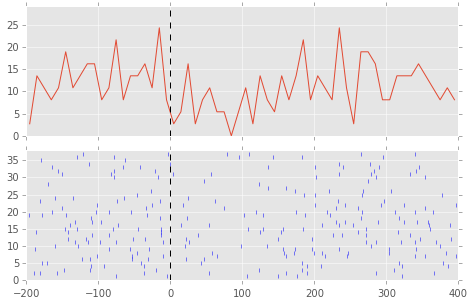

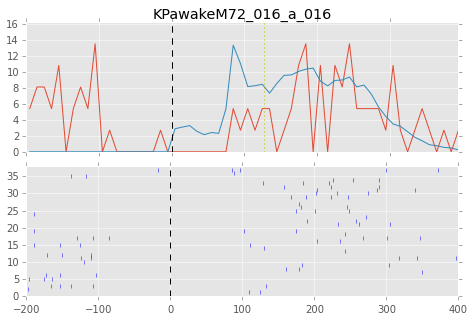

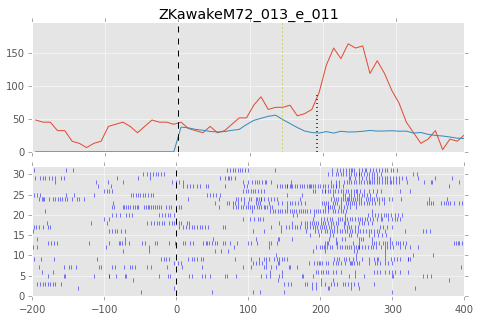

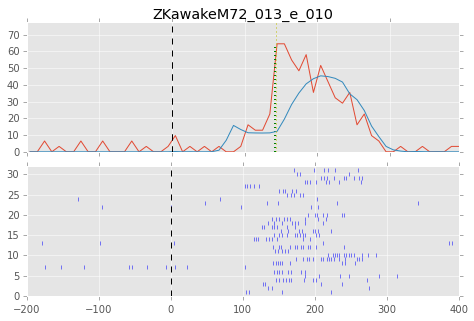

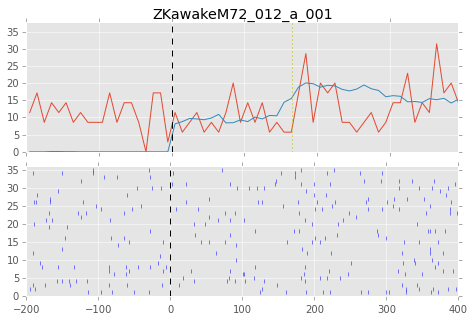

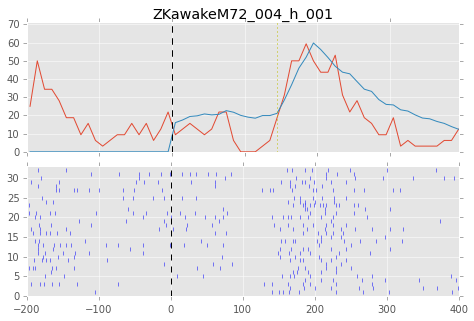

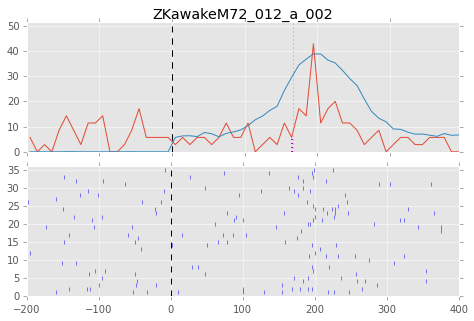

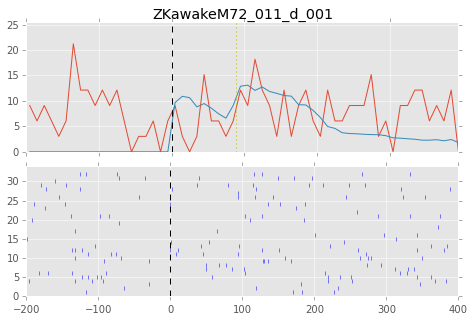

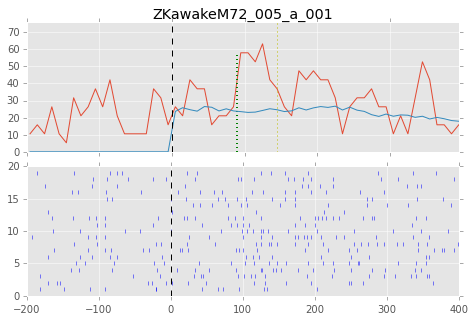

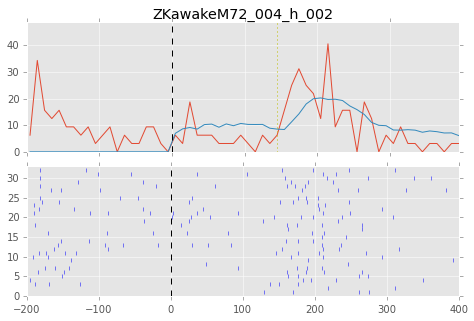

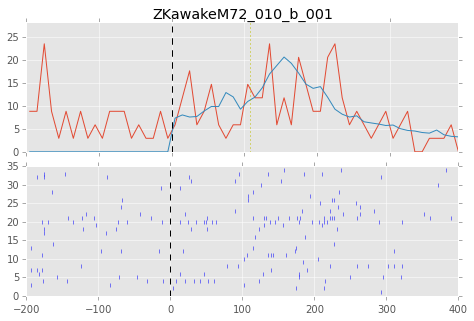

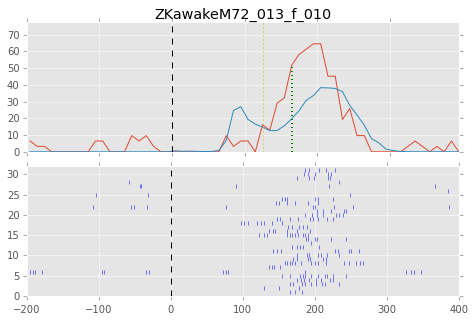

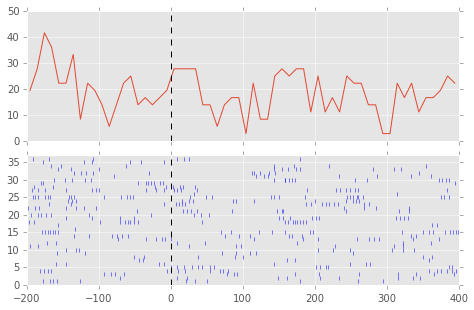

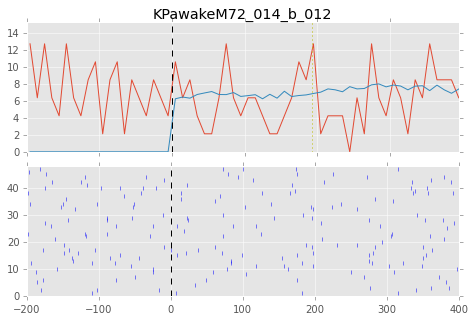

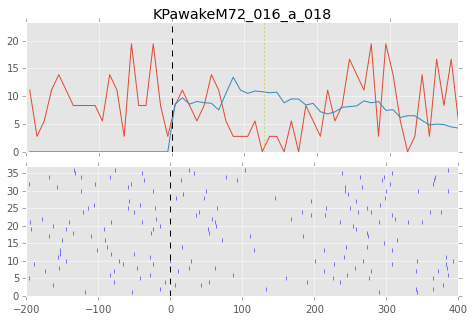

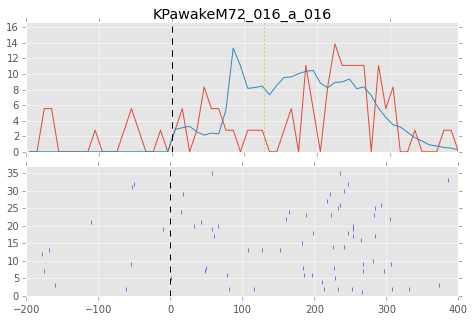

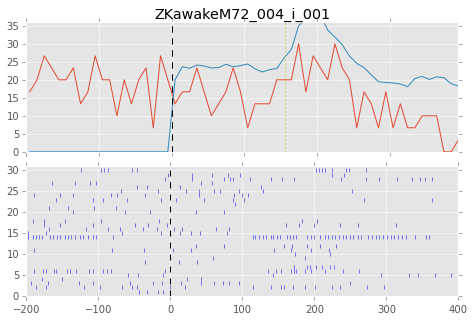

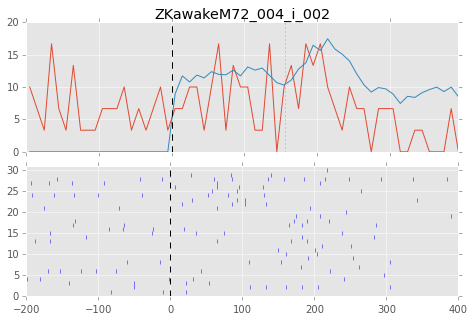

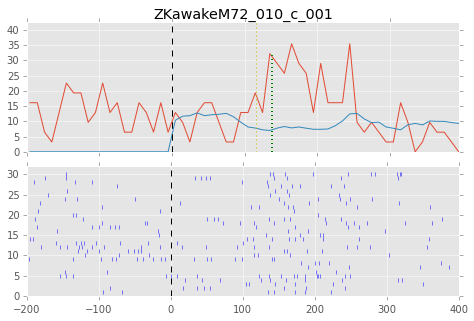

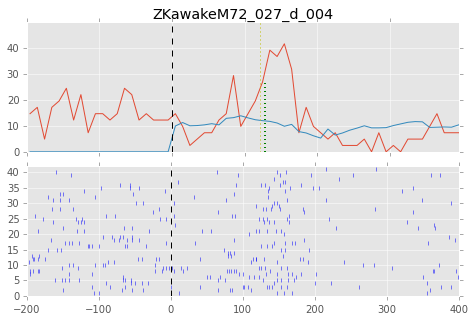

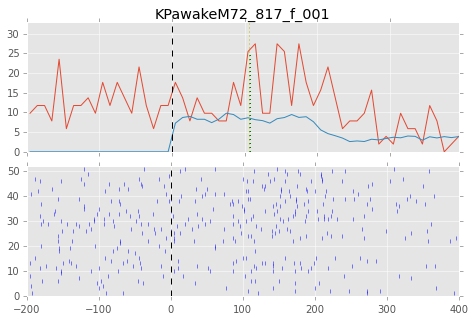

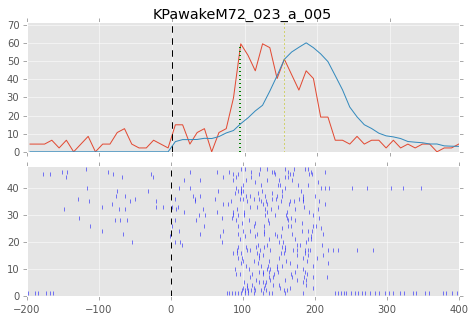

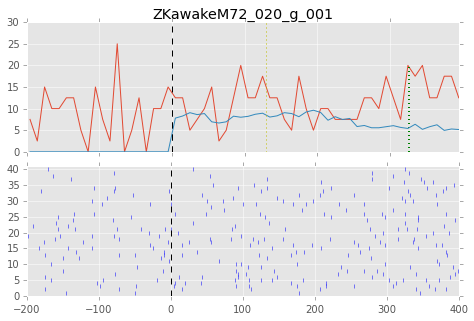

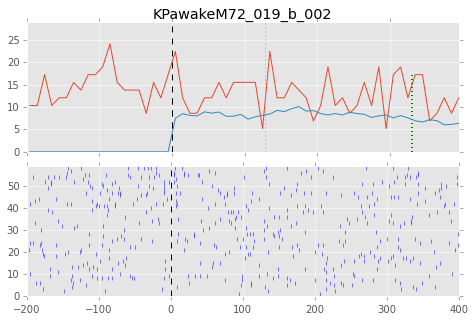

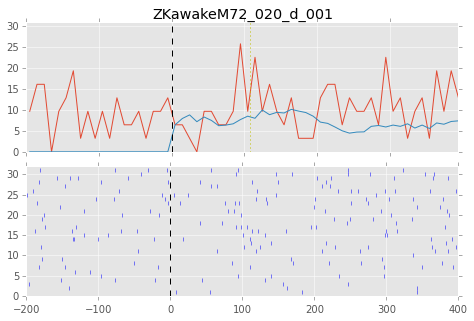

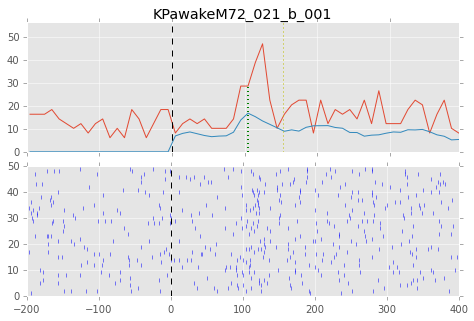

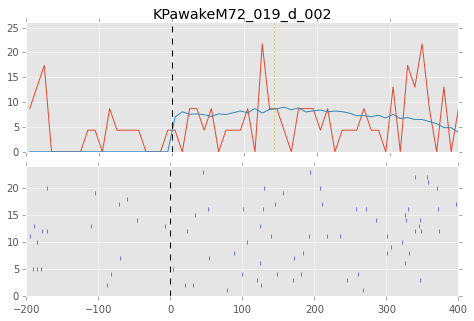

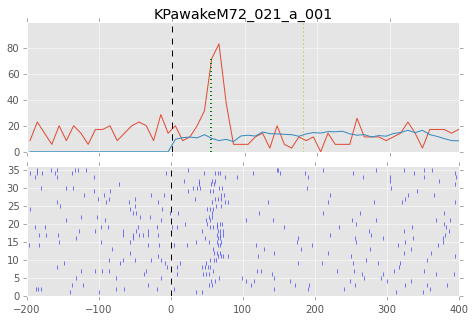

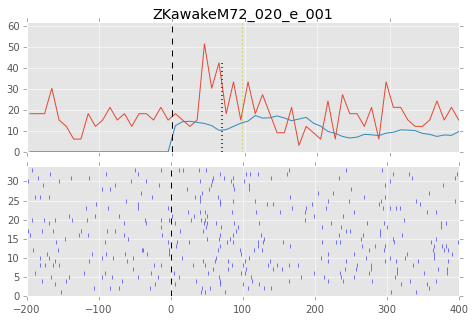

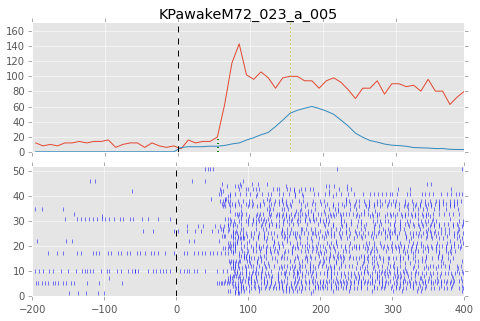

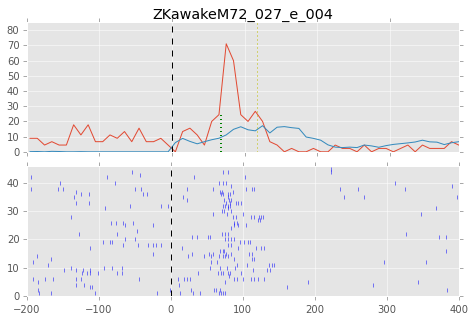

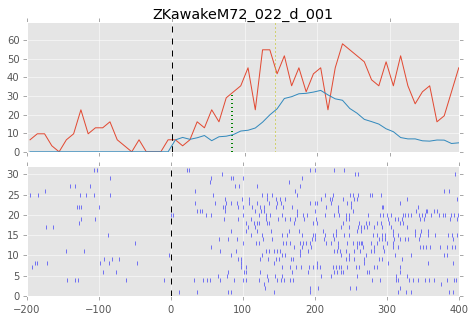

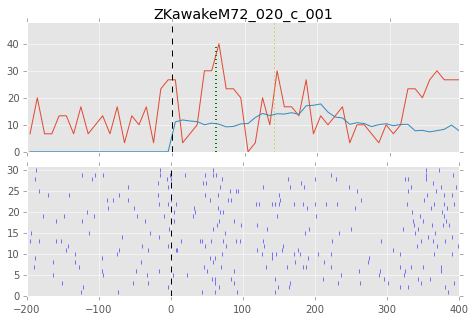

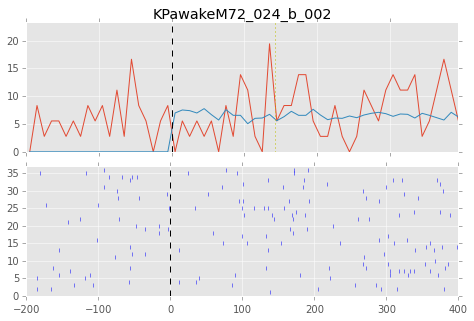

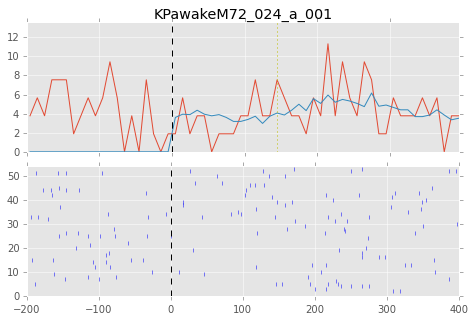

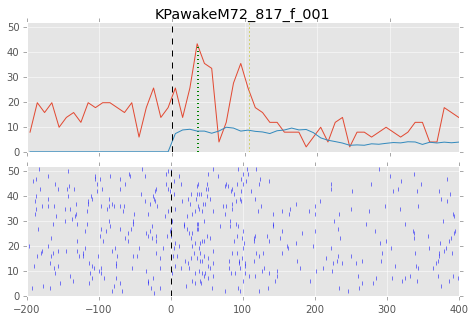

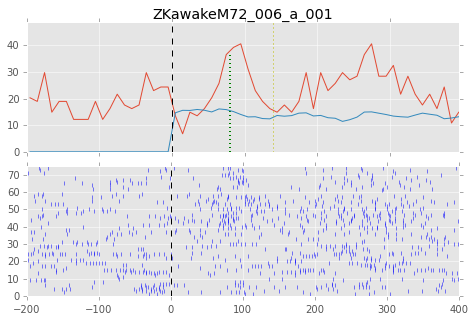

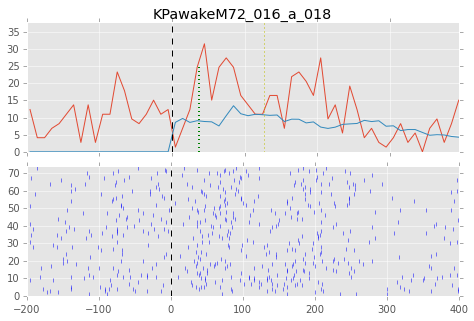

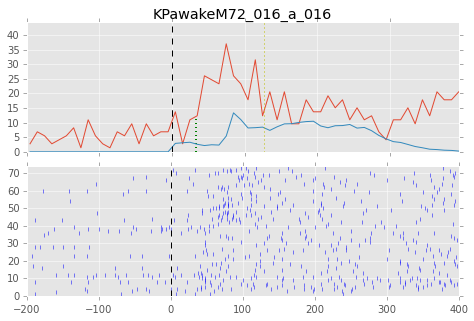

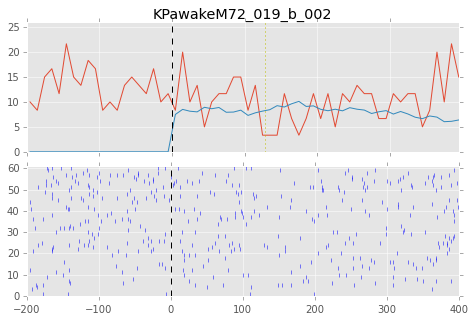

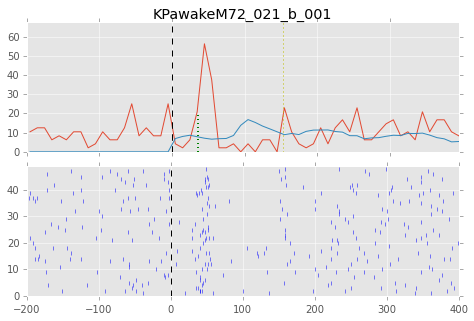

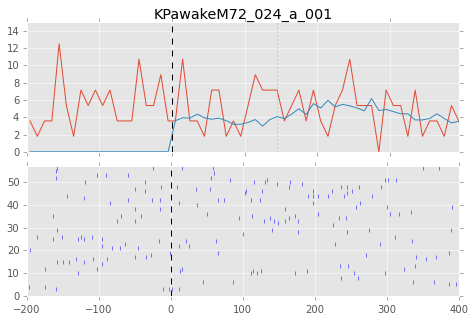

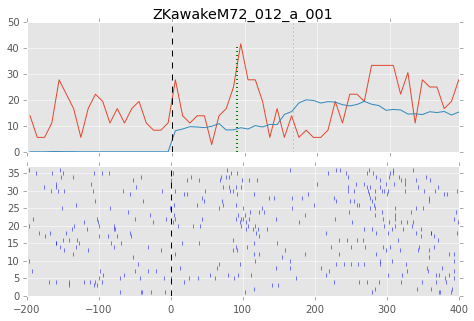

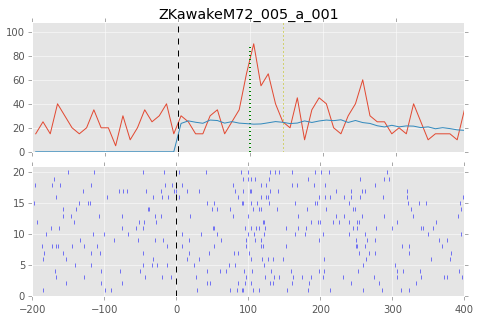

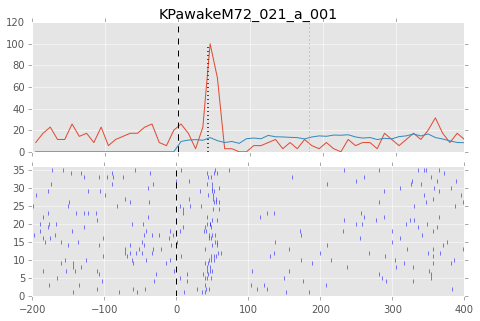

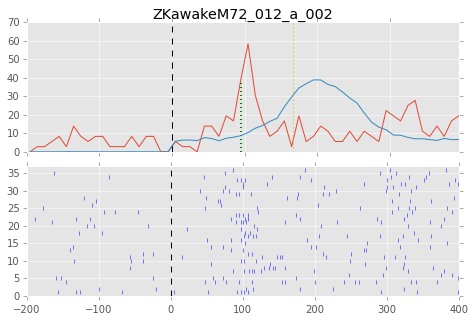

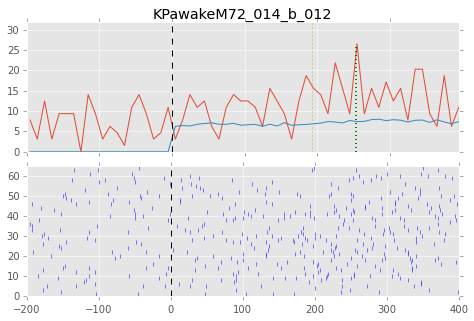

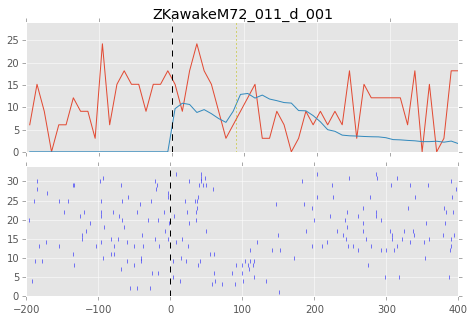

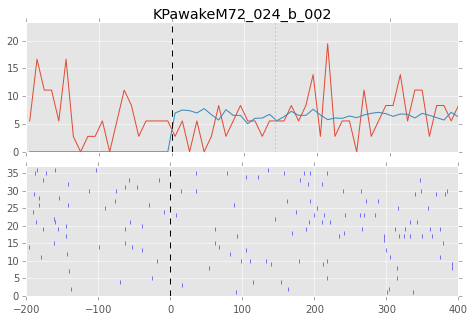

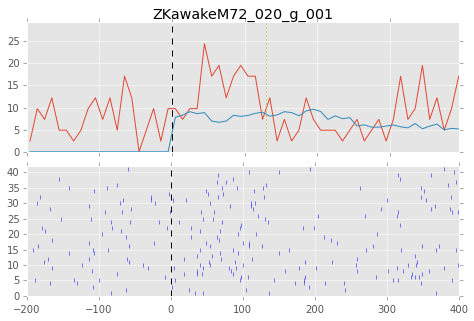

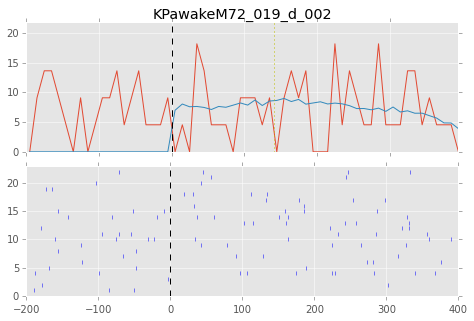

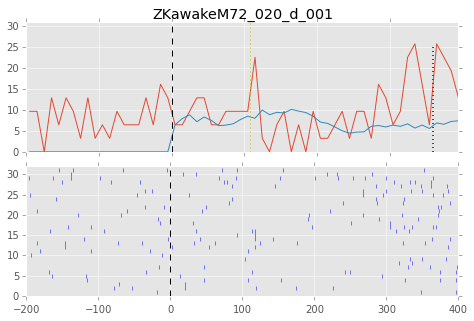

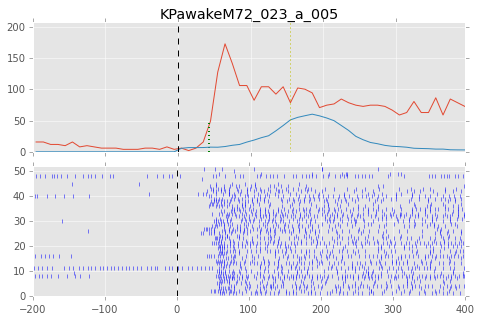

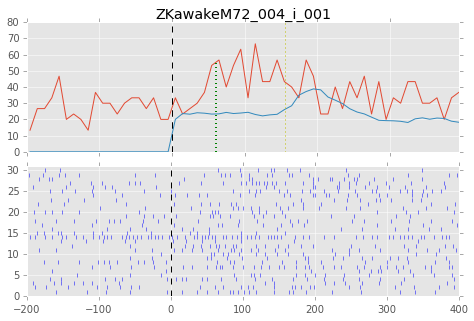

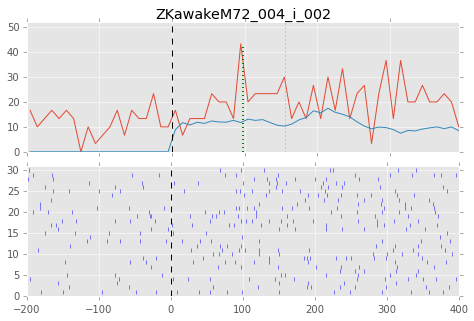

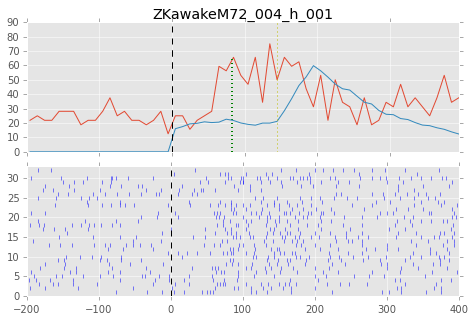

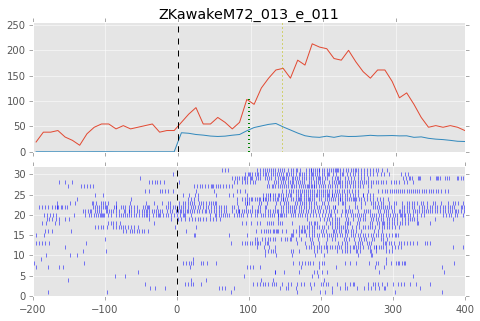

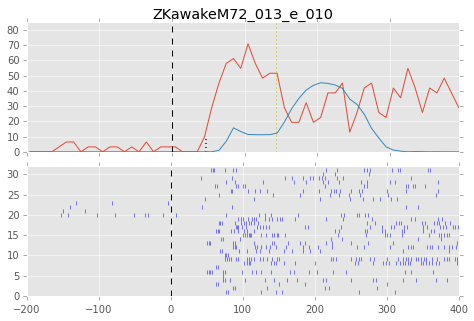

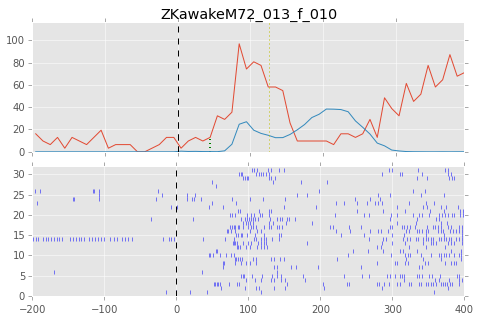

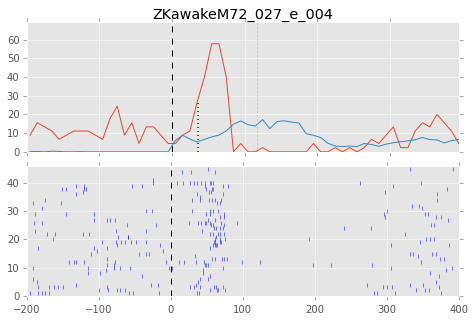

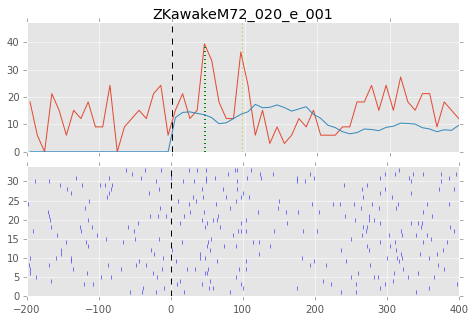

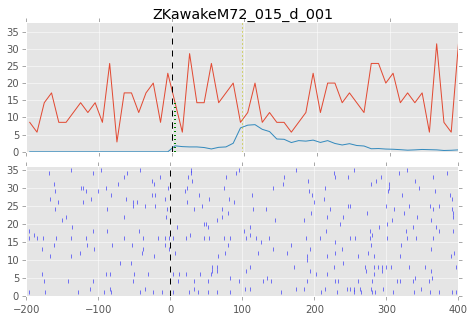

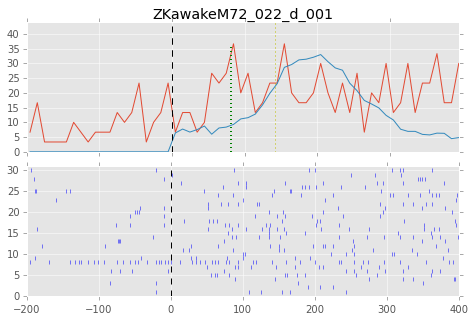

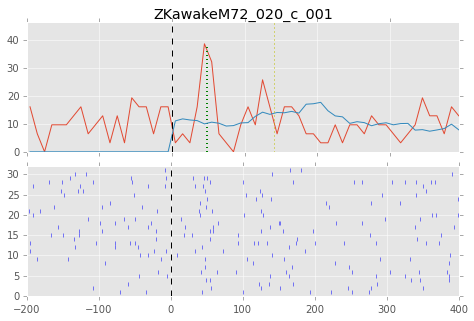

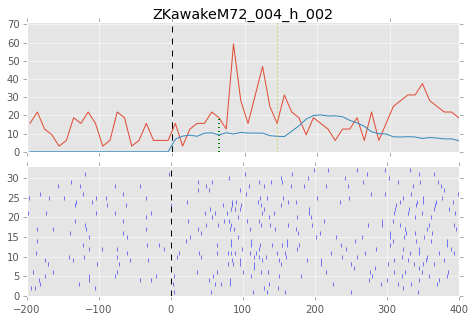

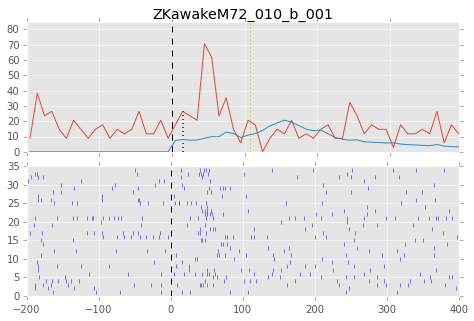

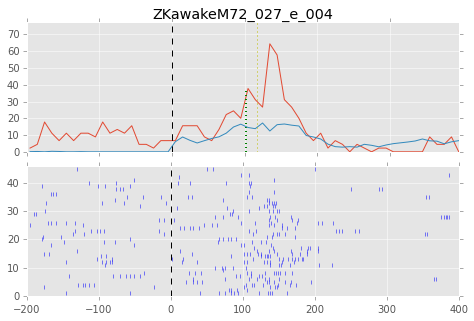

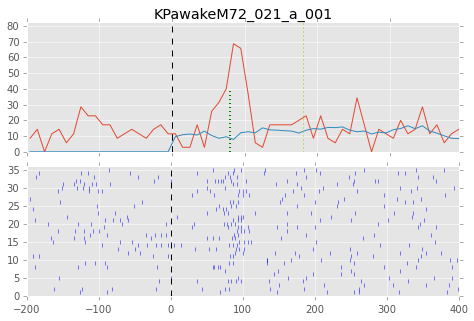

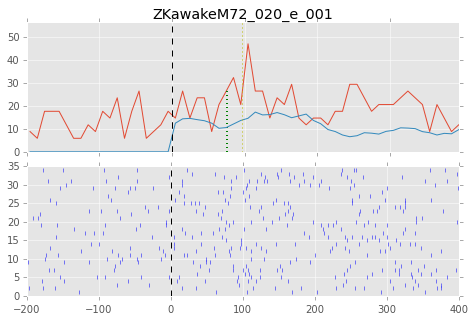

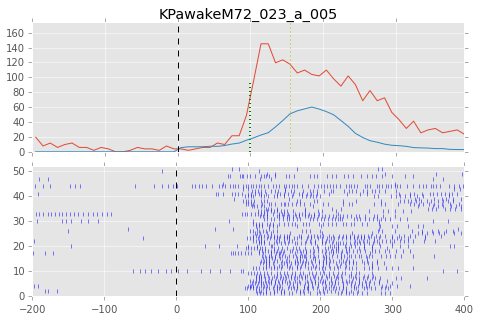

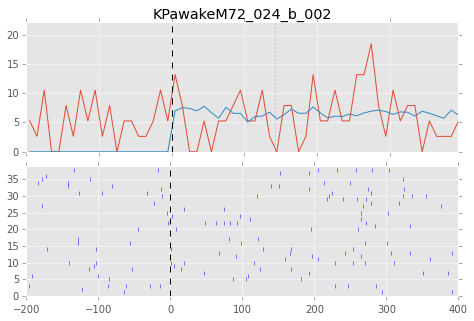

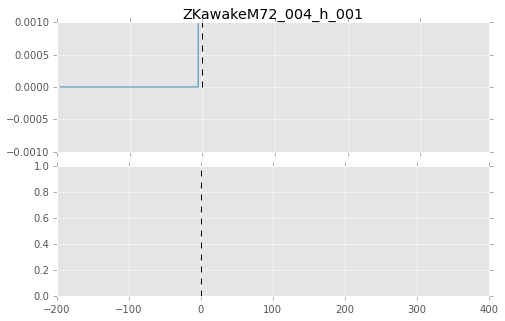

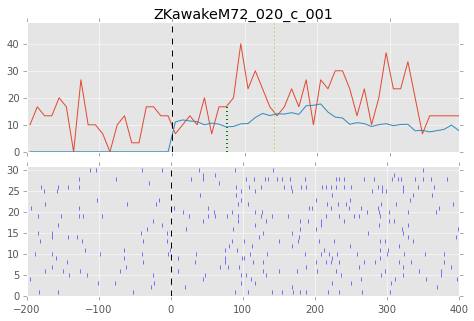

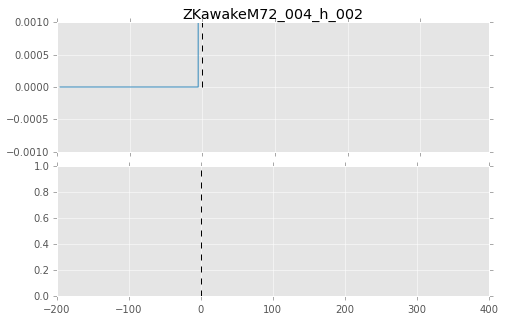

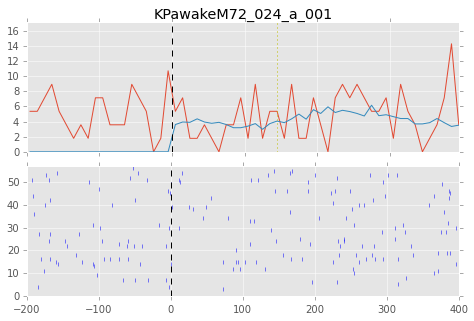

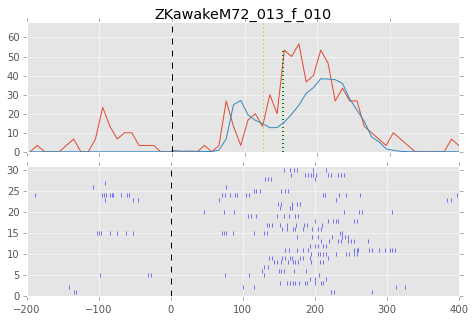

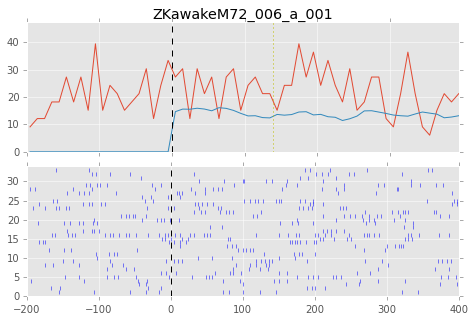

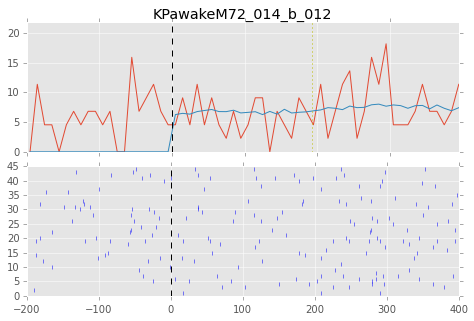

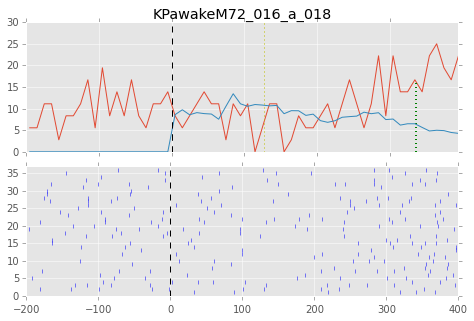

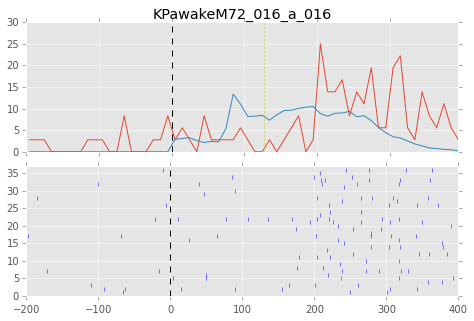

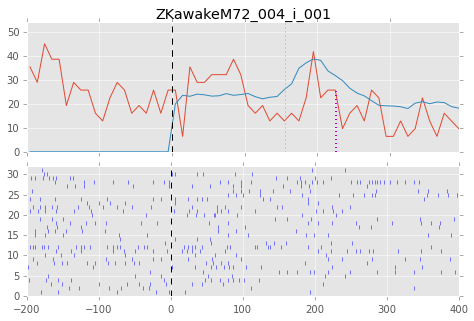

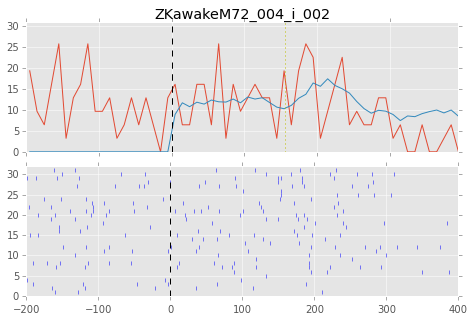

In [28]:
import multiprocessing

def worker(procnum, stim_list):
    #print str(procnum)
    warp = False
    bin_size = 15
    p=0.05
    if type(stim_list) is not list:
        stim_list = [stim_list]
    for stim in stim_list:
        for r_name, r in list(stim.responses.iteritems()):
            try:
                r.get_response_onset(warped=warp, bin_size=bin_size, p_ks=p)
                r.get_spike_count()
                #r.plot(warped=warp)
            except:
                print 'fail in ' + r_name


procs = 8
jobs =[]
n_stim = len(all_odors)
stim_per_proc = int(math.ceil(n_stim/procs))

for i in range(0, procs):
    keys = all_odors.keys()[i*stim_per_proc: (i+1)*stim_per_proc]
    stim = [all_odors[key] for key in keys]
   
    if not stim == []:
        print keys
        print i
        process = multiprocessing.Process(target=worker(i, stim))
        jobs.append(process)

[j.start() for j in jobs]
[j.join() for j in jobs]
                                      


In [42]:
#plot all the responses to all the stimuli
response_row = np.zeros(1, dtype=[('stim', '|S32'), ('resp', '|S32'), ('latency', 'f4'), ('onset_lvl','f4'), 
                                  ('spikes_inh', 'f4'), ('spikes_exh', 'f4'), ('spikes', 'f4'), ('ratio','f4')]) 
litrals = np.zeros_like(response_row)
#print litrals
warp = False
bin_size = 15
p=0.05
for st_name, stim in all_odors.iteritems():
    #print st_name
    #print stim.responses.keys()
    for r_name, r in list(stim.responses.iteritems()):
        this_resp = np.zeros_like(response_row)
        this_resp['stim'] = st_name
        this_resp['resp'] = r_name
        this_resp['latency'] = r.response_onset['onset']
        this_resp['onset_lvl'] = r.response_onset['response'] - r.response_onset['baseline']
        this_resp['spikes_inh'] = r.spikes['inh']
        this_resp['spikes_exh'] = r.spikes['exh']
        this_resp['spikes'] = this_resp['spikes_inh'] + this_resp['spikes_exh']
        this_resp['ratio'] = this_resp['spikes_inh']/this_resp['spikes_exh']
        litrals = np.append(litrals, this_resp)
        #r.plot(warped=warp)

In [30]:
r=all_odors['2-4-dimethyl'].responses['KPawakeM72_014_b_012']

(0, 32)

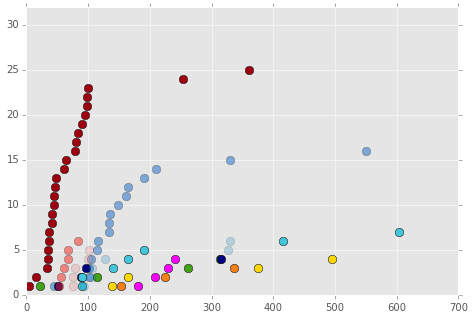

In [48]:
prop = 'ratio'

feature_fig = plt.figure()
ax = feature_fig.add_axes([0, 0, 1, 1])

n_recs = 0
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = 'v'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])

# ax.set_ylim(0, n_recs+1)

# prop = 'spikes_inh'
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = '^'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])
    
prop = 'latency'
litrals.sort(order = 'latency')
for odor, stim in all_odors.iteritems():
    #print odor
    feat = litrals[litrals['stim'] == odor][prop]
    #print feat
    stim.plot_pars['marker'] = 'o'
    stim.plot_pars['ms'] = 8
    ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
    n_recs = max(n_recs, feat.shape[0])

ax.set_ylim(0, n_recs+1)

(0, 182)

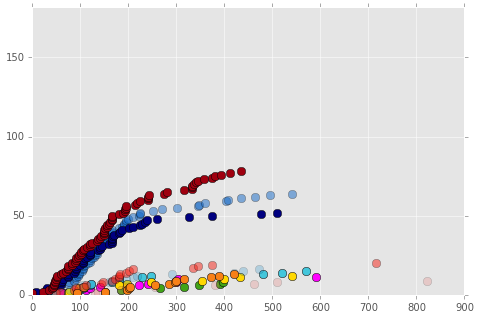

In [60]:
feature_fig = plt.figure()
ax = feature_fig.add_axes([0, 0, 1, 1])

n_recs = 0
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = 'v'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])

# ax.set_ylim(0, n_recs+1)

# prop = 'spikes_inh'
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = '^'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])
    
prop = 'latency'
non_litrals.sort(order = prop)
for odor, stim in all_odors.iteritems():
    #print odor
    feat = non_litrals[non_litrals['stim'] == odor][prop]
    #print feat
    stim.plot_pars['marker'] = 'o'
    stim.plot_pars['ms'] = 8
    ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
    n_recs = max(n_recs, feat.shape[0])

ax.set_ylim(0, n_recs+1)